In [21]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import pygad
import itertools
import random
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams["figure.figsize"] = (10, 7)

In [23]:
data = pd.read_csv("data_excerpt.csv")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date,ticker,Adj Close
0,167.992183,169.144127,163.720385,164.987518,2996200.0,0.0,0.0,2021-01-04,MMM,NaN
1,165.121926,166.312276,163.816386,164.709152,2295300.0,0.0,0.0,2021-01-05,MMM,NaN
2,165.803479,168.539358,165.150702,167.214615,3346400.0,0.0,0.0,2021-01-06,MMM,NaN
3,164.689944,166.513868,159.506191,162.923630,5863400.0,0.0,0.0,2021-01-07,MMM,NaN
4,162.395658,162.750837,158.018264,159.947769,4808100.0,0.0,0.0,2021-01-08,MMM,NaN
...,...,...,...,...,...,...,...,...,...,...
167695,179.080002,182.220001,178.179993,181.309998,2339000.0,0.0,0.0,2022-04-28,ZTS,NaN
167696,180.000000,181.860001,176.789993,177.250000,2251800.0,0.0,0.0,2022-04-29,ZTS,NaN
167697,176.389999,177.250000,171.550003,174.669998,3513000.0,0.0,0.0,2022-05-02,ZTS,NaN
167698,174.679993,176.869995,173.589996,175.139999,2152200.0,0.0,0.0,2022-05-03,ZTS,NaN


In [24]:
df = data.copy()
start_date = "2021-04-01"
end_date = "2022-03-01"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
df = df[["ticker", "date", "Close"]].rename(columns={"Close": "price"}).reset_index(drop=True)
tickers = df["ticker"].unique()
tickers_map = {i : j for i,j in zip(tickers, range(len(tickers)))}
tickers_map_reverse = {j : i for i,j in zip(tickers, range(len(tickers)))}

df["ticker_index"]  = df["ticker"].map(tickers_map)
firsts = (df.groupby('ticker').transform('first'))
df["adj_price"] = df["price"] / firsts["price"]
df = df[["ticker", "ticker_index", "date", "adj_price"]]

## Drop OGN as it joined SP500 midway
df = df[df["ticker"] != "OGN"]

In [25]:
df.groupby("ticker").count().sort_values("date")

,ticker_index,date,adj_price
ticker,,,
A,231,231,231
NVR,231,231,231
NVDA,231,231,231
NUE,231,231,231
NTRS,231,231,231
...,...,...,...
EMR,231,231,231
EMN,231,231,231
EL,231,231,231


#### Genetic algorithm

Below we try to find the best combination of 10 stocks that give the best return over the defined time period

In [26]:
## Define fitness function and utils

def portfolio_generate(df, tickers):
    portfolio = df[df['ticker_index'].isin(tickers)]
    portfolio = portfolio.groupby("date", as_index=False).sum()
    portfolio = portfolio.sort_values("date")
    return portfolio

def portfolio_return(portfolio):
    first_price = portfolio["adj_price"].iloc[0]
    last_price = portfolio["adj_price"].iloc[-1]
    return last_price / first_price - 1

def portfolio_risk(portfolio):
    portfolio["daily_change"] = portfolio["adj_price"].diff(1)
    portfolio["daily_change"] = portfolio["daily_change"] / portfolio["adj_price"]

    return portfolio["daily_change"].std()

def fitness_func(ga_instance, solution, solution_idx):
    portfolio = portfolio_generate(df, solution)
    ret = portfolio_return(portfolio)
    ris = portfolio_risk(portfolio)
    fitness = ret / ris
    return fitness

def visualize(df, solution):
    solution_fitness = fitness_func(None, solution, None)
    portfolio  = portfolio_generate(df, solution)
    portfolio["adj_price"] = (portfolio["adj_price"] / portfolio["adj_price"].iloc[0] ) * 100
    ax = portfolio.plot.line(x="date", y="adj_price")
    ax.set_ylim(90, 190)
    ret = round(portfolio_return(portfolio) * 100, 1)
    ris = round(portfolio_risk(portfolio) * 100, 1)
    
    print(f"Parameters of the best solution : {[tickers_map_reverse[i] for i in solution]}")
    print(f"Return: {ret}%")
    print(f"Risk: {ris}%")
    print(f"Risk adjusted return = {round(solution_fitness,1)}%")


In [27]:
## Define Genetic Algorithm

fitness_function = fitness_func

num_generations = 30
num_genes = 10

sol_per_pop = 90
num_parents_mating =  50

init_range_low = 0
init_range_high = 497
gene_type = int

parent_selection_type = "sss"
keep_parents = 30

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 30

In [28]:
## Initiate and run genetic algorithm

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_type=gene_type,
                       allow_duplicate_genes=False,
                       random_seed=2)
ga_instance.run()
for i,j in zip (ga_instance.best_solutions, ga_instance.best_solutions_fitness):
  print([(tickers_map_reverse[k],k) for k in sorted(i)],j)

c:\Users\Patrick\anaconda3\lib\site-packages\pygad\helper\unique.py:222: UserWarning: You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.
  if not self.suppress_warnings: warnings.warn("You set 'allow_duplicate_genes=False' but there is no enough values to prevent duplicates.")
c:\Users\Patrick\anaconda3\lib\site-packages\pygad\helper\unique.py:92: UserWarning: Failed to find a unique value for gene with index 5 whose value is 141. Consider adding more values in the gene space or use a wider range for initial population or random mutation.
  if not self.suppress_warnings: warnings.warn("Failed to find a unique value for gene with index {gene_idx} whose value is {gene_value}. Consider adding more values in the gene space or use a wider range for initial population or random mutation.".format(gene_idx=duplicate_index, gene_value=solution[duplicate_index]))
c:\Users\Patrick\anaconda3\lib\site-packages\pygad\helper\unique.py:222: UserWarning: You set 

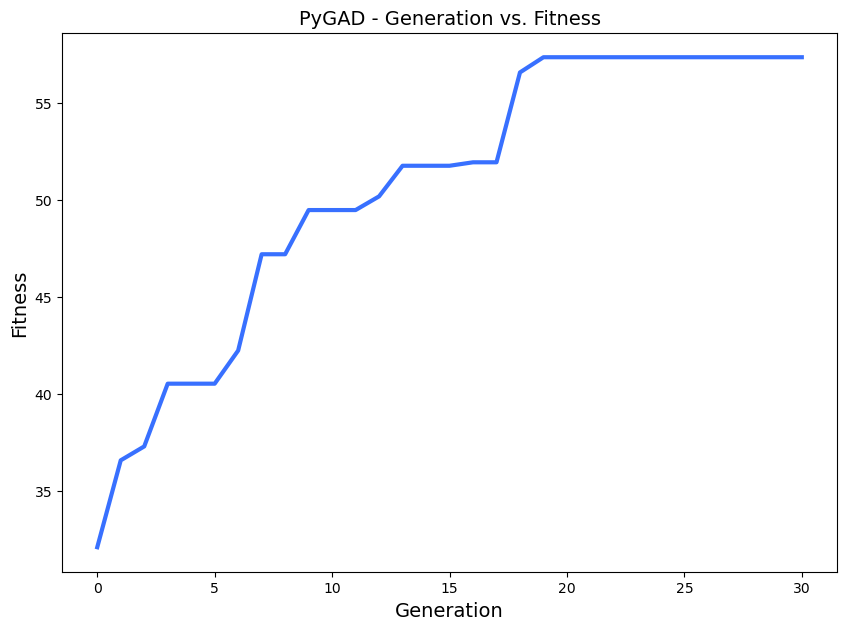

Parameters of the best solution : ['KR', 'DVN', 'WM', 'COST', 'COP', 'PG', 'ORLY', 'CERN', 'EQR', 'PSA']
Return: 48.8%
Risk: 0.9%
Risk adjusted return = 57.4%


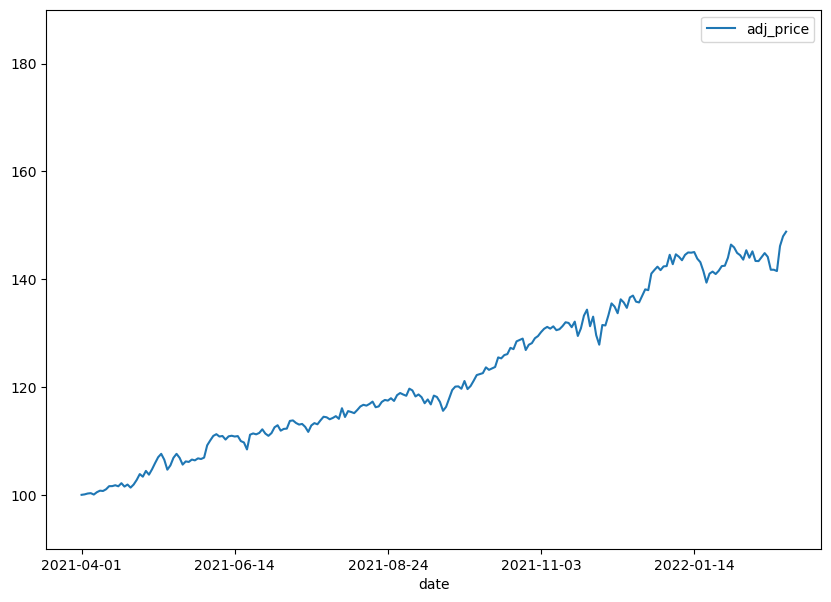

In [29]:
## Plot training, best resuls

ga_instance.plot_fitness(save_dir=None)
[solution, _, __] = ga_instance.best_solution()
visualize(df, solution)

Parameters of the best solution : ['DVN', 'APA', 'MRO', 'COP', 'CF', 'FTNT', 'OXY', 'FANG', 'NVDA', 'MOS']
Return: 88.9%
Risk: 2.1%
Risk adjusted return = 42.8%


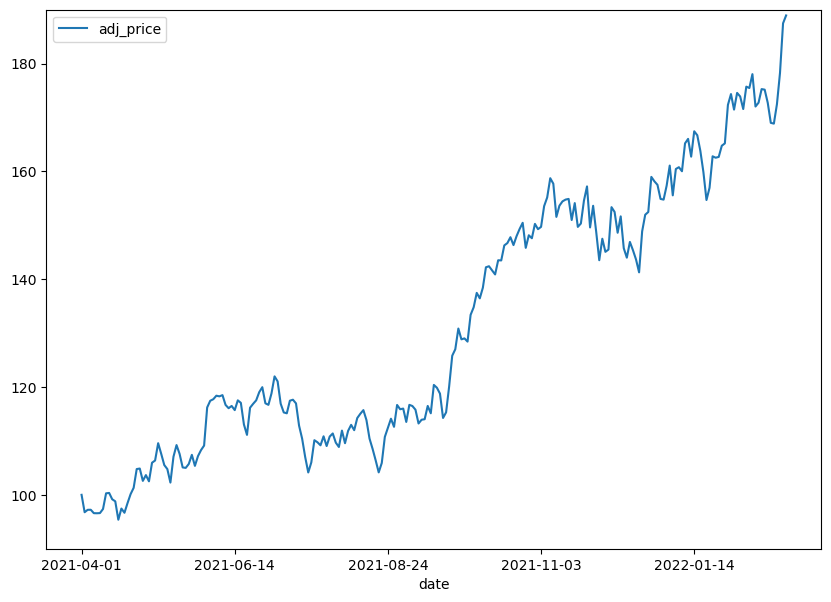

In [30]:
## Top 10 performers benchmark

firsts = df.groupby("ticker_index", as_index=False).first()
firsts = firsts.rename({"adj_price": "first_price"}, axis=1)[["ticker_index", "first_price"]]
lasts = df.groupby("ticker_index", as_index=False).last()
lasts = lasts.rename({"adj_price": "last_price"}, axis=1)[["ticker_index", "last_price"]]

df_ = firsts.merge(lasts, on="ticker_index", how="left")
df_["return"] = df_["last_price"] / df_["first_price"]
df_ = df_.sort_values("return", ascending=False)
best_return = df_.head(10)["ticker_index"].unique()

visualize(df, best_return)

Parameters of the best solution : ['MMM', 'AOS', 'ABT', 'ABBV', 'ABMD', 'ACN', 'ATVI', 'ADM', 'ADBE', 'AAP', 'AMD', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'ANTM', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'BKR', 'BLL', 'BAC', 'BBWI', 'BAX', 'BDX', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'CHRW', 'CDNS', 'CZR', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'CNC', 'CNP', 'CDAY', 'CERN', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CTXS', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CPRT', 'GLW', 'CTVA', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS'

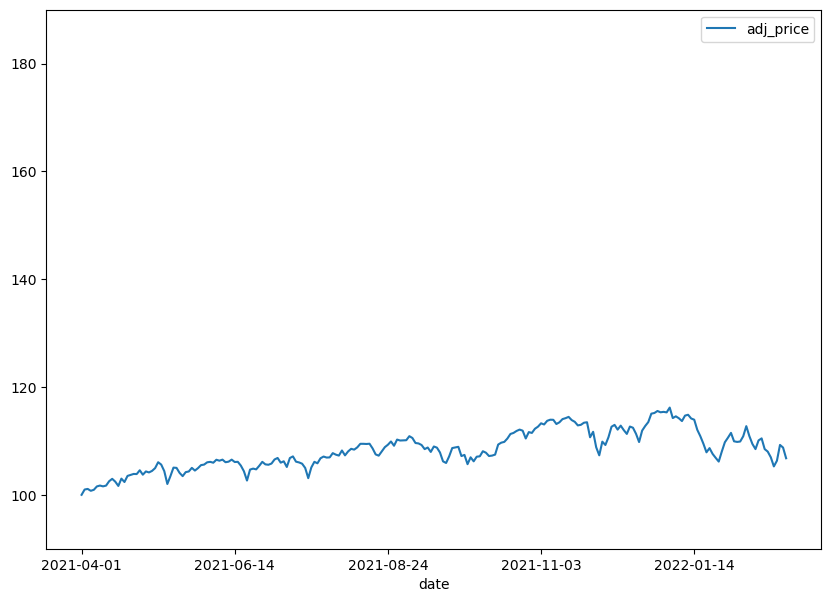

In [31]:
## S&P 500 benchmark

visualize(df, df["ticker_index"].unique())